In [10]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet
import regex as re
import  matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold
from sklearn import metrics
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from xgboost import XGBClassifier

In [11]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

In [12]:
print(f'Train data shape: {train_data.shape}\nTest data shape: {test_data.shape} ' )

Train data shape: (159571, 4)
Test data shape: (63978, 4) 


# Data preprocessing 

In [13]:
train_data.head()


,Unnamed: 0,id,comment_text,toxic
0,0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0
1,1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0
2,2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0
3,3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0
4,4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0


In [14]:
def clean_text(text):
    text =  text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"\r", "", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "that is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"'bout", "about", text)
    text = re.sub(r"'til", "until", text)
    text = re.sub(r"[!#$%&'()*+,-./:;<=>?@[\]^_`{|}~]", "", text)
    text = re.sub("(\\W)"," ",text) 
    #pattern = with or without(http),://, one or more non-white space character, OR www, .,one or more non-white space character
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub(r"http\S+", '', text)
    return text

In [15]:
def lemmatize_vers(words):
    """Lemmatize words in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos = 'v')
        lemmas.append(lemma)
    return lemmas

In [16]:
train_data['comment_text_new'] = train_data['comment_text'].apply(clean_text)
test_data['comment_text'] = test_data['comment_text'].apply(clean_text)

In [17]:
#comments after cleaning text
train_data[['comment_text','comment_text_new']].head()

,comment_text,comment_text_new
0,Explanation\nWhy the edits made under my usern...,explanation why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,daww he matches this background colour i am se...
2,"Hey man, I'm really not trying to edit war. It...",hey man i am really not trying to edit war it ...
3,"""\nMore\nI can't make any real suggestions on ...",more i cannot make any real suggestions on i...
4,"You, sir, are my hero. Any chance you remember...",you sir are my hero any chance you remember wh...


In [18]:
#tokenize words to remove stepwords and for lemmatization
#train_data['comment_text'] = train_data['comment_text_new']
train_data['comment_text_new'] = train_data['comment_text_new'].apply(lambda x: word_tokenize(x.lower()))
test_data['comment_text'] = test_data['comment_text'].apply(lambda x: word_tokenize(x.lower()))

In [19]:
#comments after tokenization text
train_data[['comment_text','comment_text_new']].head()

,comment_text,comment_text_new
0,Explanation\nWhy the edits made under my usern...,"[explanation, why, the, edits, made, under, my..."
1,D'aww! He matches this background colour I'm s...,"[daww, he, matches, this, background, colour, ..."
2,"Hey man, I'm really not trying to edit war. It...","[hey, man, i, am, really, not, trying, to, edi..."
3,"""\nMore\nI can't make any real suggestions on ...","[more, i, can, not, make, any, real, suggestio..."
4,"You, sir, are my hero. Any chance you remember...","[you, sir, are, my, hero, any, chance, you, re..."


In [20]:
def remove_stopwords(word_tokens):
    stop_words = stopwords.words('english')
    negative_sw = [word for word in stop_words if word.find("n't") != -1]
    negative_sw.append('not')
    new_stop_words=set(stop_words) - set(negative_sw)
    return [word for word in word_tokens if not word in new_stop_words]

In [21]:
#train_data['comment_text'] = train_data['comment_text_new']
train_data['comment_text_new'] = train_data['comment_text_new'].apply(remove_stopwords)
test_data['comment_text'] = test_data['comment_text'].apply(remove_stopwords)

In [22]:
#comments after removing stop words 
train_data[['comment_text','comment_text_new']].head()

,comment_text,comment_text_new
0,Explanation\nWhy the edits made under my usern...,"[explanation, edits, made, username, hardcore,..."
1,D'aww! He matches this background colour I'm s...,"[daww, matches, background, colour, seemingly,..."
2,"Hey man, I'm really not trying to edit war. It...","[hey, man, really, not, trying, edit, war, guy..."
3,"""\nMore\nI can't make any real suggestions on ...","[not, make, real, suggestions, improvement, wo..."
4,"You, sir, are my hero. Any chance you remember...","[sir, hero, chance, remember, page]"


In [23]:
#train_data['comment_text'] = train_data['comment_text_new']
train_data['comment_text_new'] = train_data['comment_text_new'].apply(lemmatize_vers)
test_data['comment_text'] = test_data['comment_text'].apply(lemmatize_vers)

In [24]:
#comments after lemmatization 
train_data[['comment_text','comment_text_new']].head()

,comment_text,comment_text_new
0,Explanation\nWhy the edits made under my usern...,"[explanation, edit, make, username, hardcore, ..."
1,D'aww! He matches this background colour I'm s...,"[daww, match, background, colour, seemingly, s..."
2,"Hey man, I'm really not trying to edit war. It...","[hey, man, really, not, try, edit, war, guy, c..."
3,"""\nMore\nI can't make any real suggestions on ...","[not, make, real, suggestions, improvement, wo..."
4,"You, sir, are my hero. Any chance you remember...","[sir, hero, chance, remember, page]"


In [25]:
train_data['comment_text'] = train_data['comment_text_new']
train_data['comment_text'] = train_data['comment_text'].apply(lambda x: ' '.join(x))
test_data['comment_text'] =test_data['comment_text'].apply(lambda x: ' '.join(x))

In [26]:
train_data['comment_text'][0]

'explanation edit make username hardcore metallica fan revert not vandalisms closure gas vote new york dolls fac please not remove template talk page since retire now892053827'

# Checking target distribution

<AxesSubplot:xlabel='toxic', ylabel='Count'>

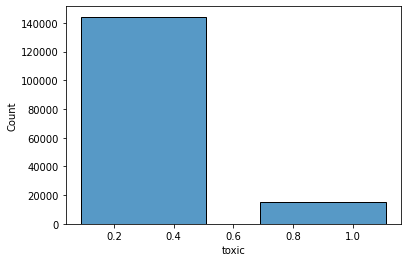

In [27]:
sb.histplot(data=train_data['toxic'],  binwidth=0.6, shrink = 0.7)

In [28]:
over = RandomOverSampler(sampling_strategy=0.5)
under = RandomUnderSampler(sampling_strategy=0.7)

# first performing oversampling to minority class
X_over, y_over = over.fit_resample(train_data[['id','comment_text']], train_data['toxic'])
print(f"Oversampled: {Counter(y_over)}")

# now to comine under sampling 
X_combined_sampling, y_combined_sampling = under.fit_resample(X_over, y_over)
print(f"Combined Random Sampling: {Counter(y_over)}")

Oversampled: Counter({0: 144277, 1: 72138})
Combined Random Sampling: Counter({0: 144277, 1: 72138})


<AxesSubplot:xlabel='toxic', ylabel='Count'>

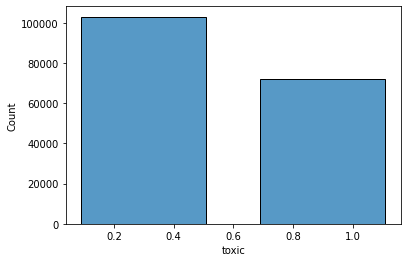

In [29]:
sb.histplot(data=y_combined_sampling,  binwidth=0.6, shrink = 0.7)

### for visualization

In [30]:
def visualize_coefficients(classifier, feature_names, n_top_features=25):
# get coefficients with large absolute values 
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
# plot them
    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * n_top_features), feature_names[interesting_coefficients], rotation=60, ha="right");

In [31]:
def plot_grid_scores(grid, param_name):
    #plt.plot(grid.param_grid[param_name], grid.cv_results_['mean_train_score'],
    #color='green', label='train')
    plt.plot(grid.param_grid[param_name], grid.cv_results_['mean_test_score'],
    color='red', label='test')
    plt.legend();

# Models prep

In [32]:
seed = 7

#x_train,x_test,y_train,y_test =  train_test_split(X_combined_sampling['comment_text'],y_combined_sampling, test_size = 0.3,random_state =seed )

### TfidfVectorizer + LogisticRegression

In [39]:

text_pipe_logit = Pipeline([
    ('tfidf', TfidfVectorizer(strip_accents='unicode', analyzer='word', sublinear_tf=True, ngram_range=(1,2),max_df=0.25)),
    ('classifier', LogisticRegression(n_jobs=-1, random_state=seed)),
])

text_pipe_logit.fit(X_combined_sampling['comment_text'], y_combined_sampling)
print(text_pipe_logit.score(X_combined_sampling['comment_text'], y_combined_sampling))


cv= StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

parameters = {
 #   'tfidf__max_df': (0.25, 0.5, 0.75),
 #   'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C': (1,10), 
    'classifier__solver': ['lbfgs', 'liblinear']
}

grid_logit = GridSearchCV(text_pipe_logit, parameters, cv=cv, scoring='f1', n_jobs=-1)

grid_logit.fit(X_combined_sampling['comment_text'], y_combined_sampling)
print(grid_logit.best_params_, grid_logit.best_score_)
#plot_grid_scores(grid_logit, 'logisticregression__C')
#grid_logit.score(x_test, y_test)

0.9842401479519612


C:\Users\RudkevichV\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\RudkevichV\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\RudkevichV\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\

{'classifier__C': 10, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'} 0.9757440570766314


In [40]:
from sklearn.metrics import confusion_matrix
print('Confusion Matrix : \n' + str(confusion_matrix(y_combined_sampling, grid_logit.predict(X_combined_sampling['comment_text']))))

Confusion Matrix : 
[[102892    162]
 [    46  72092]]


In [41]:
X_test_data = test_data['comment_text']
y_test_data = test_data['toxic']

test_pred = grid_logit.predict(X_test_data)

In [42]:

print('Confusion Matrix : \n' + str(confusion_matrix(y_test_data,test_pred)))
print(f1_score(y_test_data,test_pred))

Confusion Matrix : 
[[52454  5434]
 [  790  5300]]
0.6300523062291965


In [66]:
for i in range(len(test_pred)):
    if y_test_data[i] != test_pred[i] and test_pred[i]==1:
        print(i, X_test_data[i])

1 dear god site horrible
27 burn hell revoke talk page access
61 black mamba itis ponious snake word not kill many people king cobra kill many people india
78 shameless canvas hello diannaa thank block horrible puke translate page get mad total piece garbage thank
79 hell justin
87 buffoon synonyms bozo buffo clown comedian comic fool harlequin humorist idiot jerk jester joker merryandrew mime mimic mummer playboy prankster ridicule stooge wag wit zany
99 lewd sex china
102 bitch creek cow camp idaho hey head look one indeed place name bitch creek cow camp want let know folks idaho need not worry
110 hello everyone tell freak
120 um opinion belive dbz tenchaichi 3 last original bodikai ps2 bodikai 3 good virtua fighter tekken doa well know fight game come reality notice everything think fact base think highly unimpaortant mediocre eye others actually research subject havent even state anything game start say thats crappy series not good lol anyway even research hardcore evidence say ga

### TfidfVectorizer + XGBoost

In [40]:
xgb_pipe = Pipeline([
    ('tfid', TfidfVectorizer(strip_accents='unicode', analyzer='word',stop_words= 'english', sublinear_tf=True, ngram_range=(1,2),max_df=0.25 )), 
    ('xgboostclassfier', XGBClassifier(random_state = seed))])

param_xgb = {'xgboostclassfier__eval_metric': ['auc'],
              'xgboostclassfier__scale_pos_weight': [100],
              'xgboostclassfier__n_estimators': [500],
              'xgboostclassfier__max_depth': [2,3,4,5]}

                  #learning_rate= [0.1],
                  #min_child_weight= [1,3,5,7],
                  #gamma=[0.01,0.05,0.1,0.5],
                  #subsample= [1.0,0.8,0.6],
                  #colsample_bytree= [0.4,0.6,0.8,1.0], 
                  #reg_lambda= [0.0,0.01,0.1,0.5,1.0], #1.0
                  #reg_alpha= [0.0],
                  #n_jobs=[12]
                  
cv = KFold(n_splits=5, shuffle=True, random_state = seed)

grid_search_tune = GridSearchCV(xgb_pipe, param_xgb, cv=cv, n_jobs=2, verbose=3)
grid_search_tune.fit(x_train, y_train)

print("Best parameters set:")
print (grid_search_tune.best_estimator_.steps)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters set:
[('tfid', TfidfVectorizer(max_df=0.25, ngram_range=(1, 2), stop_words='english',
                strip_accents='unicode', sublinear_tf=True)), ('xgboostclassfier', XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=500,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=7,
              reg_alpha=0, reg_lambda=1, ...))]


In [42]:
grid_search_tune.best_params_

{'xgboostclassfier__eval_metric': 'auc',
 'xgboostclassfier__max_depth': 5,
 'xgboostclassfier__n_estimators': 500,
 'xgboostclassfier__scale_pos_weight': 100}

In [43]:
grid_search_tune.best_score_

0.8130569470306627

In [45]:
xgb_pipe_f = Pipeline([
    ('tfid', TfidfVectorizer(strip_accents='unicode', analyzer='word',stop_words= 'english', sublinear_tf=True, ngram_range=(1,2),max_df=0.25 )), 
    ('xgboostclassfier', XGBClassifier(eval_metric = 'auc', max_depth =5,n_estimators=500, scale_pos_weight=100,  random_state = seed))])

xgb_pipe_f.fit(X_combined_sampling['comment_text'], y_combined_sampling)

X_test_data = test_data['comment_text']
y_test_data = test_data['toxic']

test_data_pred_proba = xgb_pipe_f.predict(X_test_data)
f1_score_t = f1_score(y_test_data, test_data_pred_proba)
print(f1_score_t)

0.3533177397513234
